In [1]:
import numpy as np
import time

# Simulated Annealing

Solve the Sudoku problem with Simulated Annealing. You can design your own algorithm or simply refer to [Metaheuristics_can_solve_Sudoku_puzzles](https://www.researchgate.net/publication/220403361_Metaheuristics_can_solve_Sudoku_puzzles). 

The code provided below starts with making a problem instance and ends by visualizing the running process of SA.

In [2]:
# making a problem instance
def make_grid_python(n):
    grid = np.empty((n**2, n**2), int)
    x = 0
    for i in range(n):
        for j in range(n):
            for k in range(n**2):
                grid[n*i+j, k] = x%(n**2) + 1
                x += 1
            x += n
        x += 1
    return grid

def make_grid_numpy(n):
    return np.fromfunction(lambda i, j: (i*n+i//n+j)%(n**2)+1, (n**2, n**2), dtype=int)

# a comparison between native python and numpy
# vary n to see their performances
n = 10
%timeit make_grid_python(n)
%timeit make_grid_numpy(n)

# test
grid = make_grid_numpy(3)
grid

4.02 ms ± 77.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
83.6 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([[1, 2, 3, 4, 5, 6, 7, 8, 9],
       [4, 5, 6, 7, 8, 9, 1, 2, 3],
       [7, 8, 9, 1, 2, 3, 4, 5, 6],
       [2, 3, 4, 5, 6, 7, 8, 9, 1],
       [5, 6, 7, 8, 9, 1, 2, 3, 4],
       [8, 9, 1, 2, 3, 4, 5, 6, 7],
       [3, 4, 5, 6, 7, 8, 9, 1, 2],
       [6, 7, 8, 9, 1, 2, 3, 4, 5],
       [9, 1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)

In [3]:
class Sudoku:
    @classmethod
    def create(cls, n, seed=303):
        rng = np.random.default_rng(seed)
        init_grid = make_grid_numpy(n)

        # randomly mask out some cells to create a problem instance
        # cells marked by *1* is given and fixed
        mask = rng.integers(0, 2, size=init_grid.shape)
        grid = init_grid*mask

        return cls(n, mask, grid, seed)

    def __init__(self, n, mask, grid, seed) -> None:
        self.seed = seed
        self.mask = mask
        self.grid = grid
        self.n = n
        self.all = set(range(1, n**2+1))

    def value(self):
        # TODO: evaluate the current state, return a scalar value 
        cost = 0

        for row in self.grid:
            arr = [True for _ in range(self.n ** 2)]
            for num in row:
                arr[num-1] = False
            cost += sum(arr)

        for j in range(self.n ** 2):
            arr = [True for _ in range(self.n ** 2)]
            for i in range(self.n ** 2):
                arr[ self.grid[i][j]-1 ] = False
            cost += sum(arr)

        return cost
        #raise NotImplementedError()


    def local_search(self):
        # TODO: apply your neighborhood search operator to get the next state
        emptyPos = np.where(self.mask == 0)
        emptyPos = list(zip(emptyPos[0], emptyPos[1]))
        a, b = random.randint(0, len(emptyPos)-1), random.randint(0, len(emptyPos)-1)
        a, b = emptyPos[a], emptyPos[b]
        x, y = int(a[0]/self.n), int(a[1]/self.n)
        while True:
            b = random.randint(0, len(emptyPos)-1)
            b = emptyPos[b]
            if b != a and int(b[0]/self.n) == x and int(b[1]/self.n) == y:
                break

        temp_grid = self.grid.copy()
        temp_grid[a] = temp_grid[a]^temp_grid[b]
        temp_grid[b] = temp_grid[a]^temp_grid[b]
        temp_grid[a] = temp_grid[a]^temp_grid[b]
        next_state = Sudoku(self.n, self.mask, temp_grid, self.seed)


        return next_state

    def init_solution(self):
        rng = np.random.default_rng(self.seed)
        n = self.n
        grid = self.grid.reshape(n, n, n, n).transpose(0, 2, 1, 3)
        for I in np.ndindex(n, n):
            idx = grid[I]==0
            grid[I][idx] = rng.permutation(list(self.all-set(grid[I].flat)))
        return self
        
    def __repr__(self) -> str:
        return self.grid.__repr__()

# test
sudoku = Sudoku.create(3)
sudoku.init_solution()
sudoku
sudoku.value()

33

In [4]:
import random


def simulated_annealing(initial:Sudoku, schedule, halt, log_interval=200):
    state = initial.init_solution()
    t = 0           # time step
    T = schedule(t) # temperature
    f = [state.value()] # a recording of values
    while not halt(T):
        T = schedule(t)
        new_state = state.local_search()
        new_value = new_state.value()
        # TODO: implement the replacement here
        if new_value < state.value():
            state = new_state
            f.append(new_value)
        else:
            P = np.exp((state.value() - new_value)/T)

            ret = random.random()
            if ret < P:
                print("accept!", P, ((state.value() - new_value)/T), T)
                state = new_state
                f.append(new_value)
        if new_value == 0:
            print("find solution!")
            break
        # update time and temperature
        if t % log_interval == 0:
            print(f"step {t}: T={T}, current_value={state.value()}")
        t += 1
        T = schedule(t)
    print(f"step {t}: T={T}, current_value={state.value()}")
    return state, f

In [5]:
import matplotlib.pyplot as plt

# define your own schedule and halt condition
# run the algorithm on different n with different settings
n = 4
solution, record = simulated_annealing(
    initial=Sudoku.create(n), 
    schedule=lambda t: 0.999**t,
    halt=lambda T: T<1e-9
)
solution, solution.value()

step 0: T=1.0, current_value=125
accept! 1.0 0.0 0.999
accept! 1.0 0.0 0.997002999
accept! 1.0 0.0 0.993020965034979
accept! 1.0 0.0 0.992027944069944
accept! 0.36456691450382883 -1.00904516549629 0.991035916125874
accept! 1.0 0.0 0.9900448802097482
accept! 1.0 0.0 0.9831353223738244
accept! 1.0 0.0 0.9801888648295347
accept! 1.0 0.0 0.9782294672887404
accept! 1.0 0.0 0.9772512378214517
accept! 0.3583108762816658 -1.0263542998942456 0.9743224148844496
accept! 1.0 0.0 0.9714023696327184
accept! 1.0 0.0 0.9665550620990835
accept! 1.0 0.0 0.9655885070369844
accept! 0.354632045383437 -1.0366745189135316 0.9646229185299474
accept! 1.0 0.0 0.9607702107358118
accept! 1.0 0.0 0.959809440525076
accept! 1.0 0.0 0.9588496310845509
accept! 0.35205764424522046 -1.043960354731297 0.9578907814534663
accept! 1.0 0.0 0.9531108968798943
accept! 1.0 0.0 0.9512056281970314
accept! 0.34801380876435595 -1.0555131196375627 0.947406509114141
accept! 1.0 0.0 0.9436225637280605
accept! 1.0 0.0 0.940794525960944

accept! 1.0 0.0 0.37176444787154095
accept! 1.0 0.0 0.36916989079109375
step 1000: T=0.36769542477096373, current_value=34
accept! 1.0 0.0 0.36696040161684657
accept! 1.0 0.0 0.3665934412152297
accept! 1.0 0.0 0.3582538942048088
accept! 1.0 0.0 0.35575362775079855
accept! 0.058140918884293 -2.8448855792928978 0.351507985867239
accept! 1.0 0.0 0.34766067307893983
accept! 1.0 0.0 0.34661873369406154
accept! 1.0 0.0 0.3428249345759132
accept! 1.0 0.0 0.3421396275316959
accept! 1.0 0.0 0.34145569041626006
accept! 1.0 0.0 0.3411142347258438
accept! 1.0 0.0 0.33704330257207565
accept! 1.0 0.0 0.32838884448265493
accept! 1.0 0.0 0.3274046627873516
accept! 1.0 0.0 0.3231738463307534
accept! 1.0 0.0 0.32156120560744
accept! 1.0 0.0 0.31963665536547686
accept! 0.04282899081931184 -3.1505400501047465 0.3174058999715788
accept! 1.0 0.0 0.3117408988401201
accept! 1.0 0.0 0.31142915794127995
accept! 1.0 0.0 0.3111177287833387
accept! 1.0 0.0 0.3095652482070878
accept! 1.0 0.0 0.30925568295888073
acc

accept! 1.0 0.0 0.00014332067570488343
accept! 1.0 0.0 0.0001285130005385134
step 9000: T=0.00012285533877715932, current_value=2
accept! 1.0 0.0 0.00011363238327368625
accept! 1.0 0.0 0.00010884741241245112
accept! 1.0 0.0 0.0001033293022950754
step 9200: T=0.0001005753792851227, current_value=2
step 9400: T=8.233591652613551e-05, current_value=2
accept! 1.0 0.0 8.046287634232964e-05
step 9600: T=6.740420168817147e-05, current_value=2
accept! 1.0 0.0 6.360412560303563e-05
step 9800: T=5.5180370813963455e-05, current_value=2
accept! 1.0 0.0 4.94297392491622e-05
accept! 1.0 0.0 4.654977788317184e-05
step 10000: T=4.517334597704824e-05, current_value=2
accept! 1.0 0.0 4.410156256433448e-05
step 10200: T=3.6981106807743975e-05, current_value=2
accept! 1.0 0.0 3.413649780345052e-05
step 10400: T=3.0274539800984007e-05, current_value=2
step 10600: T=2.4784216571079923e-05, current_value=2
accept! 1.0 0.0 2.242456452587857e-05
step 10800: T=2.028956988545958e-05, current_value=2
step 11000: 

(array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
        [ 5,  8,  7,  6,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3,  4],
        [ 9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8],
        [13, 14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1],
        [ 6,  7,  8, 13, 10, 11, 12,  1, 14, 15, 16,  5,  2,  3,  4,  9],
        [10, 11, 12,  9, 14, 15, 16, 13,  2,  3,  4,  1,  6,  7,  8,  5],
        [14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2],
        [ 7, 10,  9,  8, 11, 12, 13, 14, 15, 16,  1,  2,  3,  4,  5,  6],
        [11, 12, 13, 14, 15, 16,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [15, 16,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  1,  2,  3],
        [ 8,  9, 10, 11, 12, 13, 14, 1

Text(0, 0.5, 'value')

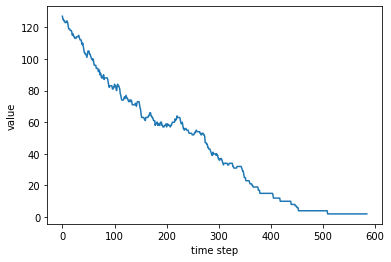

In [6]:
# visualize the curve
plt.plot(record)
plt.xlabel("time step")
plt.ylabel("value")